# XGBoost
- Author: Kimberly Yeo
- Module: Capstone
- Date: 16/2/2022

## Import packages

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import snscrape.modules.twitter as sntwitter
import nltk
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load Bitcoin and Tweets data

In [2]:
final_df = pd.read_csv("tweets_bitcoin.csv")

## TFIDF

In [3]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(final_df['Text'])

In [4]:
df1 = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
final_df.drop('Text', axis=1, inplace=True)
final_df = pd.concat([final_df, df1], axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
train = final_df[:-29].dropna()
test = final_df[-29:].dropna()

In [6]:
train.head()

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,zuckbuck,zuckerberg,zug,zulutrad,zurich,zytara,álvarez,ángel,ștefan,аre
0,2018-09-30,0.013610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-10-01,0.613488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-10-02,0.561735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-10-03,1.117252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## XGBoost Trial

In [7]:
xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, learning_rate=0.01, seed = 123)
xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

[20:53:27] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [8]:
y_pred = xgb_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 13.460
MSE: 954.495


## Create a 1-day lag for TFIDF

In [9]:
lag1_df = final_df.copy()

In [10]:
lag1_df = pd.concat([final_df["Date"], lag1_df.iloc[:,1:].shift(1)], axis=1)

## Create n-day lags for TFIDF

In [11]:
def get_lag_df(n_lag, final_df):
    lag_df = final_df.copy()
    lag_df = pd.concat([final_df[["Date", "Obs_Vol"]], lag_df.iloc[:,2:].shift(n_lag)], axis=1)
    return lag_df

In [12]:
lag_dict = {}
for i in range(1, 10):
    lag_dict["lag{}_df".format(i)] = get_lag_df(i, final_df).dropna()

In [13]:
# Lag tuning function which produces elbow plot
def lag_tuning(lag_dict, accur_metric):
    min_mae = 0
    min_mse = 0
    count = 1
    lag_score_df = pd.DataFrame(columns = ["lag", accur_metric])
    for k in lag_dict.keys():
        df = lag_dict[k]
        train = df[:-count].dropna()
        test = df[-count:].dropna()
        xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                      n_estimators = 10, learning_rate=0.01, seed = 123)
        xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
        y_pred = xgb_model.predict(test[df1.columns])
        if accur_metric == "mae":
            mae = mean_absolute_error(test["Obs_Vol"], y_pred)
            if count == 0:
                min_mae = mae
                best_lag = k
            else:
                if min_mae > mae:
                    min_mae = mae
            lag_score_df = lag_score_df.append({"lag": count, accur_metric: mae}, ignore_index=True)
        elif accur_metric == "mse":
            mse = mean_squared_error(test["Obs_Vol"], y_pred)
            if count == 1:
                min_mse = mse
                best_lag = k
            else:
                if min_mse > mse:
                    min_mse = mse
            lag_score_df = lag_score_df.append({"lag": count+1, accur_metric: mse}, ignore_index=True)
        count += 1
    plt.plot(lag_score_df["lag"], lag_score_df[accur_metric], 'go-', linewidth=2)
    plt.xlabel("lag")
    plt.ylabel(accur_metric)
    plt.show()
    return lag_score_df

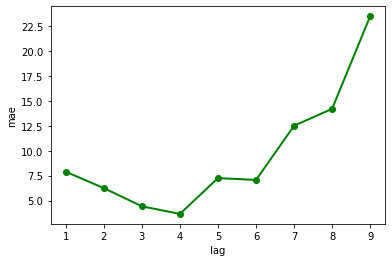

CPU times: user 2min 14s, sys: 988 ms, total: 2min 15s
Wall time: 13.6 s


,lag,mae
0,1.0,7.886376
1,2.0,6.243492
2,3.0,4.418400
3,4.0,3.654659
4,5.0,7.252171
5,6.0,7.063134
6,7.0,12.502917
7,8.0,14.204999
8,9.0,23.497424


In [14]:
%%time
lag_tuning(lag_dict, "mae")

In [15]:
# Choosing lag_4 as the best dataframe with 4-day lagged tfidf features
xgb_df = lag_dict["lag4_df"]

## Date specific feature engineering

In [16]:
xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])

In [17]:
xgb_df['Year'] = xgb_df['Date'].dt.year 
xgb_df['Month'] = xgb_df['Date'].dt.month 
xgb_df['Day'] = xgb_df['Date'].dt.day

xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek  
# xgb_df['dayofweek_name']= xgb_df['Date'].dt.weekday_name

In [18]:
xgb_df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,zurich,zytara,álvarez,ángel,ștefan,аre,Year,Month,Day,dayofweek_num
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,4,3
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,5,4
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,6,5
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,7,6
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2018,10,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,24,4
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,25,5
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,26,6
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,27,0


## Lags for observed volatility

In [19]:
def get_lags(lag_start, lag_end, df):
    for i in range(lag_start, lag_end):
        df['lag_'+str(i)] = df.Obs_Vol.shift(i)
    return df

In [20]:
xgb_df = get_lags(1, 8, xgb_df)

In [21]:
xgb_df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Month,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,5,4,0.807727,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,6,5,0.207422,0.807727,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,7,6,0.572715,0.207422,0.807727,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,8,0,0.000346,0.572715,0.207422,0.807727,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766


## Rolling window for observed volatility

In [22]:
xgb_df['rolling_mean'] = xgb_df['Obs_Vol'].rolling(window=7).mean()

In [23]:
xgb_df

,Date,Obs_Vol,aaron,aav,aayog,abaco,abakus,abandon,abat,abbc,...,Day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
4,2018-10-04,0.807727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-10-05,0.207422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,4,0.807727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-10-06,0.572715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,5,0.207422,0.807727,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-10-07,0.000346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,6,0.572715,0.207422,0.807727,NaN,NaN,NaN,NaN,NaN
8,2018-10-08,0.255549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0,0.000346,0.572715,0.207422,0.807727,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2021-09-24,23.222015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,4,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,1.743323,29.491320
1083,2021-09-25,0.279093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25,5,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,3.601447,29.016698
1084,2021-09-26,0.829626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,6,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,5.521163,28.346478
1085,2021-09-27,6.211249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27,0,0.829626,0.279093,23.222015,7.783189,46.765087,27.660570,91.885766,16.107261


## XGBoost Attempt

In [24]:
xgb_df = xgb_df.dropna()

In [25]:
df1 = xgb_df.iloc[:, 3:]

In [26]:
train = xgb_df[:-4].dropna()
test = xgb_df[-4:].dropna()

In [27]:
xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, learning_rate=0.01, seed = 123)
xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

[20:54:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [28]:
y_pred = xgb_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 4.384
MSE: 22.377


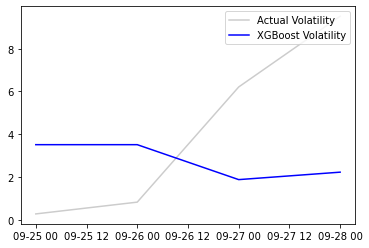

In [29]:
# Plotting estimated XGBoost volatility against actual volatility
xgb_vol = pd.DataFrame(y_pred)
xgb_vol.index = test['Date']
xgb_vol = xgb_vol.rename(columns={0: "Volatility"})

actual_vol = pd.DataFrame(test['Obs_Vol'])
actual_vol.index = test['Date']

# Plot the actual Bitcoin volatility
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot XGBoost estimated volatility
plt.plot(xgb_vol['Volatility'], color = 'blue', label = 'XGBoost Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [30]:
y_pred = xgb_model.predict(train[df1.columns])

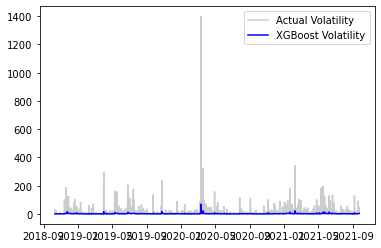

In [31]:
# Plotting estimated XGBoost volatility against actual volatility (using all training data)
xgb_vol = pd.DataFrame(y_pred)
xgb_vol.index = train['Date']
xgb_vol = xgb_vol.rename(columns={0: "Volatility"})

actual_vol = pd.DataFrame(train['Obs_Vol'])
actual_vol.index = train['Date']

# Plot the actual Bitcoin volatility
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot XGBoost estimated volatility
plt.plot(xgb_vol['Volatility'], color = 'blue', label = 'XGBoost Volatility')

plt.legend(loc = 'upper right')
plt.show()

## Finetuning lags for XGBoost

lag1_df
[20:58:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:53] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 7.539
MSE: 56.842


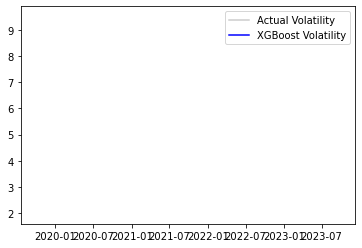

lag2_df
[20:58:55] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:56] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 5.883
MSE: 37.338


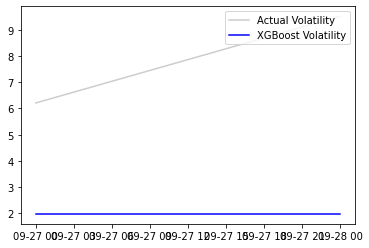

lag3_df
[20:58:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 2.812
MSE: 9.087


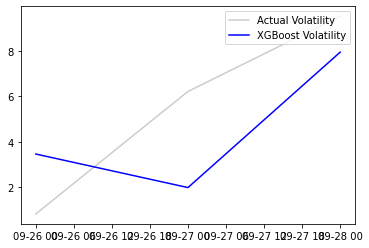

lag4_df
[20:59:01] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:03] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 4.384
MSE: 22.377


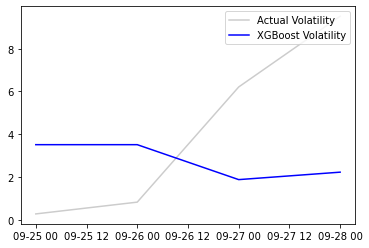

lag5_df
[20:59:04] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:06] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 5.591
MSE: 49.268


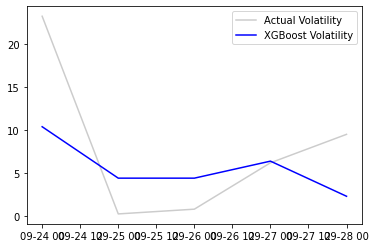

lag6_df
[20:59:08] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 7.246
MSE: 87.611


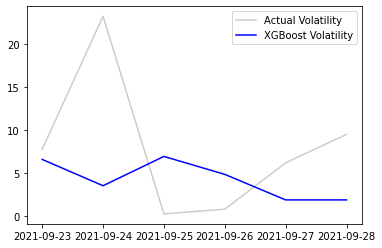

lag7_df
[20:59:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:12] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 13.452
MSE: 377.605


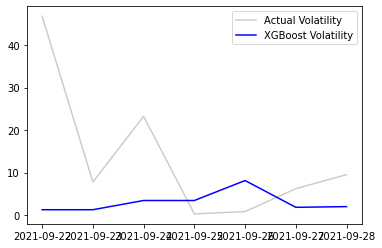

lag8_df
[20:59:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:15] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 14.337
MSE: 405.672


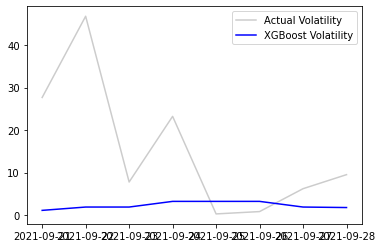

lag9_df
[20:59:17] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 22.555
MSE: 1253.356


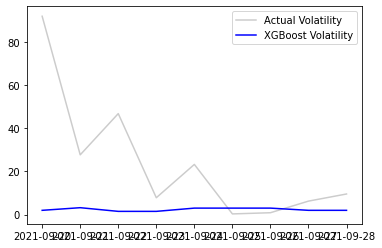

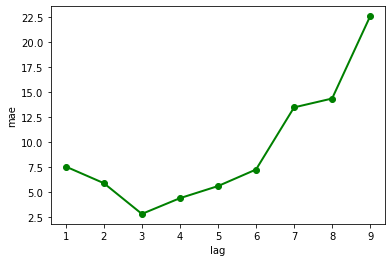

In [33]:
lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
lag_model_dict = {}
for lag in lag_dict.keys():
    print(lag)
    xgb_df = lag_dict[lag]
    
    xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])
    xgb_df['Year'] = xgb_df['Date'].dt.year 
    xgb_df['Month'] = xgb_df['Date'].dt.month 
    xgb_df['Day'] = xgb_df['Date'].dt.day
    xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek
    
    xgb_df = get_lags(1, 8, xgb_df)
    xgb_df['rolling_mean'] = xgb_df['Obs_Vol'].rolling(window=7).mean()
    
    xgb_df = xgb_df.dropna()
    df1 = xgb_df.iloc[:, 3:]
    
    lag_no = int(lag[3])
    train = xgb_df[:-(lag_no)].dropna()
    test = xgb_df[-(lag_no):].dropna()
    
    xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, learning_rate=0.01, seed = 123)
    xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
    
    lag_model_dict["model_lag{}".format(str(lag_no))] = xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
    
    y_pred = xgb_model.predict(test[df1.columns])
    mae = mean_absolute_error(test["Obs_Vol"], y_pred)
    mse = mean_squared_error(test["Obs_Vol"], y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    
    # Plotting estimated XGBoost volatility against actual volatility
    xgb_vol = pd.DataFrame(y_pred)
    xgb_vol.index = test['Date']
    xgb_vol = xgb_vol.rename(columns={0: "Volatility"})

    actual_vol = pd.DataFrame(test['Obs_Vol'])
    actual_vol.index = test['Date']

    # Plot the actual Bitcoin volatility
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

    # Plot XGBoost estimated volatility
    plt.plot(xgb_vol['Volatility'], color = 'blue', label = 'XGBoost Volatility')

    plt.legend(loc = 'upper right')
    plt.show()
    
    lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
plt.xlabel("lag")
plt.ylabel("mae")
plt.show()

In [35]:
lag_model_dict['model_lag6']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Hyperparameter and lag tuning for XGBoost

In [33]:
# param_grid = {
#             'min_child_weight': [1, 5, 10],
#             'gamma': [0.5, 2, 5],
#             'subsample': [0.6, 1.0, 1.4],
#             'colsample_bytree': [0.6, 1.0, 1.5],
#             'max_depth': [3, 5, 8]
#             }

In [42]:
param_grid = {
            'min_child_weight': [1, 5],
            'gamma': [0.5, 2],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.6, 1.0],
            'max_depth': [3, 8],
            'seed': [123],
            'learning_rate': [0.01],
            'n_estimators' : [10]
            }

In [43]:
def xgboost_tuning(param_grid):
    model_dict = {}
    lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
    for lag in lag_dict.keys():
        print(lag)
        xgb_df = lag_dict[lag]

        xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])
        xgb_df['Year'] = xgb_df['Date'].dt.year 
        xgb_df['Month'] = xgb_df['Date'].dt.month 
        xgb_df['Day'] = xgb_df['Date'].dt.day
        xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek

        xgb_df = get_lags(1, 8, xgb_df)
        xgb_df['rolling_mean'] = xgb_df['Obs_Vol'].rolling(window=7).mean()

        xgb_df = xgb_df.dropna()
        df1 = xgb_df.iloc[:, 3:]

        lag_no = int(lag[3])
        train = xgb_df[:-(lag_no)].dropna()
        test = xgb_df[-(lag_no):].dropna()

        # Hyperparameter tuning
        n_folds = 5

        xgb_model = GridSearchCV(estimator=xgb.XGBRegressor(),
                                    param_grid=param_grid,
                                    cv=KFold(n_splits=n_folds,
                                            shuffle=True),
                                     scoring="neg_mean_squared_error")

        xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

        model_dict["model_lag{}".format(str(lag_no))] = xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

        y_pred = xgb_model.predict(test[df1.columns])
        mae = mean_absolute_error(test["Obs_Vol"], y_pred)
        mse = mean_squared_error(test["Obs_Vol"], y_pred)
        print('MAE: %.3f' % mae)
        print('MSE: %.3f' % mse)

        # Plotting estimated XGBoost volatility against actual volatility
        xgb_vol = pd.DataFrame(y_pred)
        xgb_vol.index = test['Date']
        xgb_vol = xgb_vol.rename(columns={0: "Volatility"})

        actual_vol = pd.DataFrame(test['Obs_Vol'])
        actual_vol.index = test['Date']

        # Plot the actual Bitcoin volatility
        # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

        # Plot XGBoost estimated volatility
        plt.plot(xgb_vol['Volatility'], color = 'blue', label = 'XGBoost Volatility')

        plt.legend(loc = 'upper right')
        plt.show()

        lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
    plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
    plt.xlabel("lag")
    plt.ylabel("mae")
    plt.show()
    return model_dict, lag_score_df

lag1_df
MAE: 7.779
MSE: 60.509


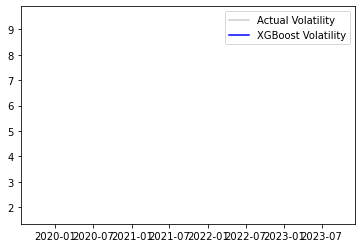

lag2_df
MAE: 5.964
MSE: 38.529


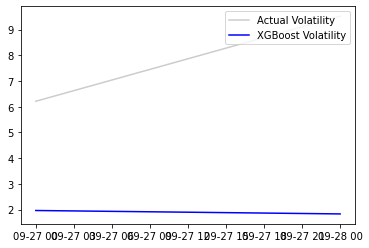

lag3_df


In [ ]:
%%time
model_dict, lag_score_df = xgboost_tuning(param_grid)

lag1_df
MAE: 10.432
MSE: 108.832


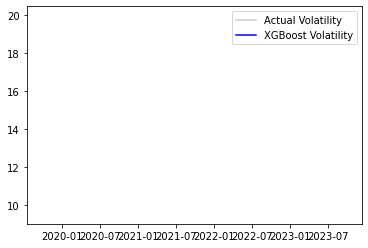

lag2_df
MAE: 14.181
MSE: 210.223


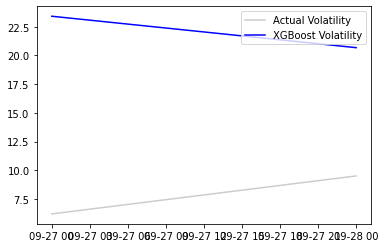

lag3_df
MAE: 23.650
MSE: 725.429


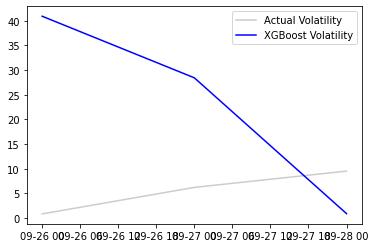

lag4_df
MAE: 25.461
MSE: 932.006


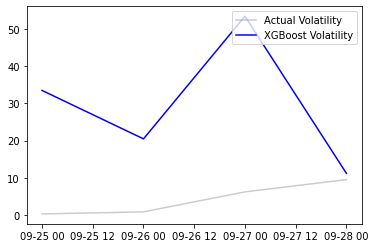

lag5_df
MAE: 21.935
MSE: 577.664


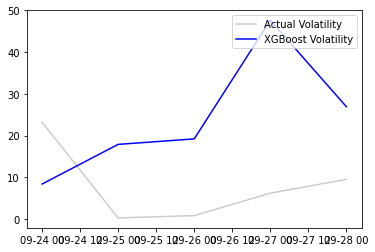

lag6_df
MAE: 14.289
MSE: 531.539


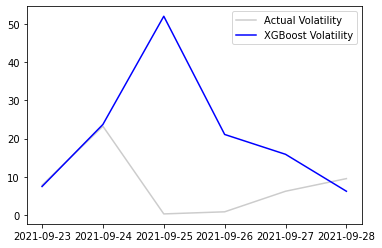

lag7_df
MAE: 18.002
MSE: 655.871


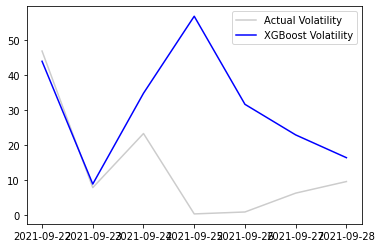

lag8_df
MAE: 15.567
MSE: 304.364


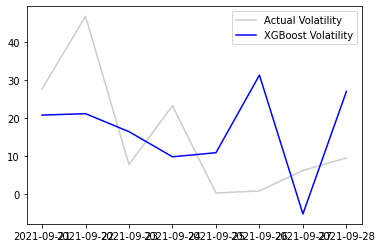

lag9_df
MAE: 31.912
MSE: 1357.549


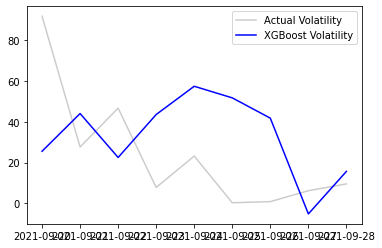

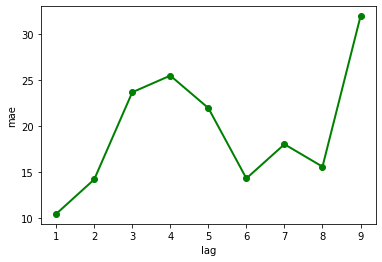

CPU times: user 1d 3h 36min 56s, sys: 20min 6s, total: 1d 3h 57min 3s
Wall time: 12h 45min 6s


In [33]:
%%time
model_dict = {}
lag_score_df = pd.DataFrame(columns = ["lag", "mae"])
for lag in lag_dict.keys():
    print(lag)
    xgb_df = lag_dict[lag]
    
    xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])
    xgb_df['Year'] = xgb_df['Date'].dt.year 
    xgb_df['Month'] = xgb_df['Date'].dt.month 
    xgb_df['Day'] = xgb_df['Date'].dt.day
    xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek
    
    xgb_df = get_lags(1, 8, xgb_df)
    xgb_df['rolling_mean'] = xgb_df['Obs_Vol'].rolling(window=7).mean()
    
    xgb_df = xgb_df.dropna()
    df1 = xgb_df.iloc[:, 3:]
    
    lag_no = int(lag[3])
    train = xgb_df[:-(lag_no)].dropna()
    test = xgb_df[-(lag_no):].dropna()
    
    # Hyperparameter tuning
    n_folds = 5

    xgb_model = GridSearchCV(estimator=xgb.XGBRegressor(),
                                param_grid=param_grid,
                                cv=KFold(n_splits=n_folds,
                                        shuffle=True),
                                 scoring="neg_mean_squared_error")
    
    xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
    
    model_dict["model_lag{}".format(str(lag_no))] = xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )
    
    y_pred = xgb_model.predict(test[df1.columns])
    mae = mean_absolute_error(test["Obs_Vol"], y_pred)
    mse = mean_squared_error(test["Obs_Vol"], y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    
    # Plotting estimated XGBoost volatility against actual volatility
    xgb_vol = pd.DataFrame(y_pred)
    xgb_vol.index = test['Date']
    xgb_vol = xgb_vol.rename(columns={0: "Volatility"})

    actual_vol = pd.DataFrame(test['Obs_Vol'])
    actual_vol.index = test['Date']

    # Plot the actual Bitcoin volatility
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

    # Plot XGBoost estimated volatility
    plt.plot(xgb_vol['Volatility'], color = 'blue', label = 'XGBoost Volatility')

    plt.legend(loc = 'upper right')
    plt.show()
    
    lag_score_df = lag_score_df.append({"lag": lag_no, "mae": mae}, ignore_index=True)
plt.plot(lag_score_df["lag"], lag_score_df["mae"], 'go-', linewidth=2)
plt.xlabel("lag")
plt.ylabel("mae")
plt.show()

In [47]:
model_dict["model_lag5"]

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mon...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tr

In [ ]:
xgb_df = lag_dict["lag4_df"]
xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])
xgb_df['Year'] = xgb_df['Date'].dt.year 
xgb_df['Month'] = xgb_df['Date'].dt.month 
xgb_df['Day'] = xgb_df['Date'].dt.day
xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek

xgb_df = get_lags(1, 8, xgb_df)
xgb_df['rolling_mean'] = xgb_df['Obs_Vol'].rolling(window=7).mean()

xgb_df = xgb_df.dropna()
df1 = xgb_df.iloc[:, 3:]

lag_no = int(lag[3])
train = xgb_df[:-(lag_no)].dropna()
test = xgb_df[-(lag_no):].dropna()

# Hyperparameter tuning
n_folds = 5

param_grid = {
            'min_child_weight': [1, 5],
            'gamma': [0.5, 2],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.6, 1.0],
            'max_depth': [3, 5]
            }

xgb_model = GridSearchCV(estimator=xgb.XGBRegressor(),
                            param_grid=param_grid,
                            cv=KFold(n_splits=n_folds,
                                    shuffle=True),
                             scoring="neg_mean_squared_error")

xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

In [45]:
param_grid = {
            'min_child_weight': [1, 5],
            'gamma': [0.5, 2],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.6, 1.0],
            'max_depth': [3, 8],
            'seed': [123],
            'learning_rate': [0.01],
            'n_estimators' : [10]
            }

MAE: 7.400
MSE: 85.443


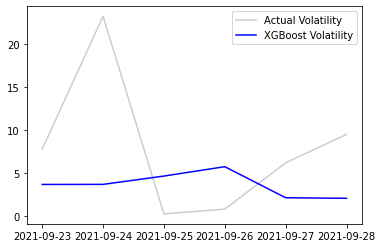

In [49]:
xgb_df = lag_dict["lag6_df"]

xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])
xgb_df['Year'] = xgb_df['Date'].dt.year 
xgb_df['Month'] = xgb_df['Date'].dt.month 
xgb_df['Day'] = xgb_df['Date'].dt.day
xgb_df['dayofweek_num'] = xgb_df['Date'].dt.dayofweek

xgb_df = get_lags(1, 8, xgb_df)
xgb_df['rolling_mean'] = xgb_df['Obs_Vol'].rolling(window=7).mean()

xgb_df = xgb_df.dropna()
df1 = xgb_df.iloc[:, 3:]

lag_no = int(lag[3])
train = xgb_df[:-6].dropna()
test = xgb_df[-6:].dropna()

# Hyperparameter tuning
n_folds = 5

xgb_model = GridSearchCV(estimator=xgb.XGBRegressor(),
                            param_grid=param_grid,
                            cv=KFold(n_splits=n_folds,
                                    shuffle=True),
                             scoring="neg_mean_squared_error")

xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

model_dict["model_lag{}".format(str(lag_no))] = xgb_model.fit(train[df1.columns], train["Obs_Vol"], verbose = True, eval_metric=mean_squared_error )

y_pred = xgb_model.predict(test[df1.columns])
mae = mean_absolute_error(test["Obs_Vol"], y_pred)
mse = mean_squared_error(test["Obs_Vol"], y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

# Plotting estimated XGBoost volatility against actual volatility
xgb_vol = pd.DataFrame(y_pred)
xgb_vol.index = test['Date']
xgb_vol = xgb_vol.rename(columns={0: "Volatility"})

actual_vol = pd.DataFrame(test['Obs_Vol'])
actual_vol.index = test['Date']

# Plot the actual Bitcoin volatility
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Obs_Vol'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot XGBoost estimated volatility
plt.plot(xgb_vol['Volatility'], color = 'blue', label = 'XGBoost Volatility')

plt.legend(loc = 'upper right')
plt.show()